In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

from pipeline.dimensionality_reduction import apply_PCA
from pipeline.ANN import build_ANN
from pipeline.training import train_and_save, plot_history
from pipeline.preprocessing import preprocess_data
from pipeline.hyperparam_tuning import run_hyperband_tuner
from pipeline.data_augmentation import augment_data_simple, augment_data_smoter
from pipeline.data_visualisation import plot_correlation, plot_feature_distributions, plot_target_distribution

In [5]:
!pip install xlrd --quiet
all_df = pd.read_excel('data/TrainDataset2025.xls', engine='xlrd')
all_df.head()

,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,1,144.0,41.0,0,0,0,1,3,3,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,TRG002178,0,142.0,39.0,1,1,0,0,3,3,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,TRG002204,1,135.0,31.0,0,0,0,1,2,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,TRG002206,0,12.0,35.0,0,0,0,1,3,3,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,TRG002210,0,109.0,61.0,1,0,0,0,2,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


# Data Analysis

In [6]:
all_df = all_df.drop(columns=['ID']) 
df = all_df.replace(999, np.nan)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 120 entries, pCR (outcome) to original_ngtdm_Strength
dtypes: float64(117), int64(3)
memory usage: 375.1 KB


,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
count,395.000000,400.000000,400.000000,400.000000,399.000000,399.000000,399.000000,397.000000,398.000000,397.000000,...,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,4.000000e+02,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.212658,56.000208,51.804674,0.547500,0.406015,0.300752,0.333333,2.400504,1.575377,1.148615,...,3.957637e-01,3.911005e-01,2.722189e+00,0.003347,5.679717e+07,178.311246,32500.032620,0.056935,0.005965,0.029322
std,0.409707,27.137584,10.948522,0.498362,0.491704,0.459161,0.471996,0.500807,0.766487,0.356157,...,1.666319e-01,1.615922e-01,7.648849e-01,0.002419,7.063846e+08,1045.453432,177545.921568,0.047179,0.008379,0.115915
min,0.000000,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,7.050000e-11,7.050000e-11,-3.200000e-16,0.000008,0.000000e+00,0.000000,0.000248,0.000000,0.000000,0.000000
25%,0.000000,38.000000,44.516769,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,...,3.199017e-01,3.184398e-01,2.340783e+00,0.001389,1.030473e+06,18.760570,0.001826,0.018628,0.000310,0.001464
50%,0.000000,55.000000,51.019507,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,...,4.095627e-01,4.054695e-01,2.814884e+00,0.002944,3.277334e+06,67.929659,0.004383,0.047740,0.002330,0.003276
75%,0.000000,73.000000,60.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,...,5.000049e-01,4.956920e-01,3.304411e+00,0.004798,9.079686e+06,157.370294,0.013769,0.085321,0.007962,0.009479
max,1.000000,144.000000,79.603012,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,2.000000,...,8.773779e-01,8.571429e-01,4.947427e+00,0.011301,1.390001e+10,20764.693790,1000000.000000,0.285100,0.060742,1.145601


In [7]:
#sorting by variance

numeric_cols = df.select_dtypes(include='number')
summary = numeric_cols.describe().T
summary['variance'] = numeric_cols.var()
summary_sorted = summary.sort_values(by='variance', ascending=False)

print(summary_sorted)

                                                    count          mean  \
original_glszm_LargeAreaHighGrayLevelEmphasis       400.0  3.000160e+08   
original_glszm_LargeAreaEmphasis                    400.0  1.038107e+08   
original_glszm_LargeAreaLowGrayLevelEmphasis        400.0  5.475941e+07   
original_glszm_ZoneVariance                         400.0  5.679717e+07   
original_ngtdm_Coarseness                           400.0  3.250003e+04   
...                                                   ...           ...   
original_ngtdm_Contrast                             400.0  5.965135e-03   
original_gldm_SmallDependenceHighGrayLevelEmphasis  400.0  1.148391e-02   
original_glszm_ZonePercentage                       400.0  3.346763e-03   
original_gldm_SmallDependenceEmphasis               400.0  5.497165e-03   
original_gldm_SmallDependenceLowGrayLevelEmphasis   400.0  4.000479e-03   

                                                             std  \
original_glszm_LargeAreaHighGra

In [8]:
#analysing missing values

print((all_df == 999).sum().sum())
cols_with_999 = all_df.columns[(all_df == 999).any()]
print(cols_with_999)

count_999_per_col = (all_df == 999).sum().sort_values(ascending=False)
print(count_999_per_col)

105
Index(['pCR (outcome)', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade',
       'Proliferation', 'HistologyType', 'LNStatus', 'Gene'],
      dtype='object')
Gene                         88
pCR (outcome)                 5
HistologyType                 3
ChemoGrade                    3
Proliferation                 2
                             ..
original_ngtdm_Busyness       0
original_ngtdm_Coarseness     0
original_ngtdm_Complexity     0
original_ngtdm_Contrast       0
original_ngtdm_Strength       0
Length: 120, dtype: int64


### Visualising RFS distribtion and correlation with features

RelapseFreeSurvival (outcome)
38.000000    11
60.000000    10
39.000000    10
31.000000     9
61.000000     9
             ..
54.916667     1
49.250000     1
48.500000     1
47.500000     1
46.916667     1
Name: count, Length: 144, dtype: int64
0.5187248461868751
0.4494120443838918


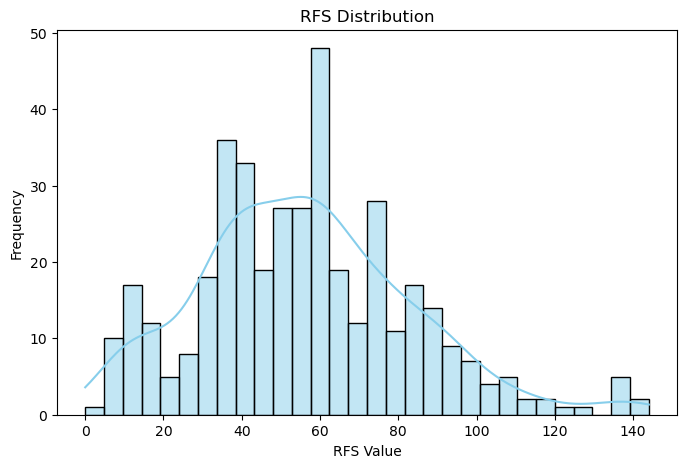

In [9]:
#visualising target distribution (RFS)
outcomes = ['RelapseFreeSurvival (outcome)', 'pCR (outcome)']
target = 'RelapseFreeSurvival (outcome)'
features = df.drop(columns=outcomes)

print(df[target].value_counts())
print(df[target].skew())
print(df[target].kurt())
plot_target_distribution(df[target])

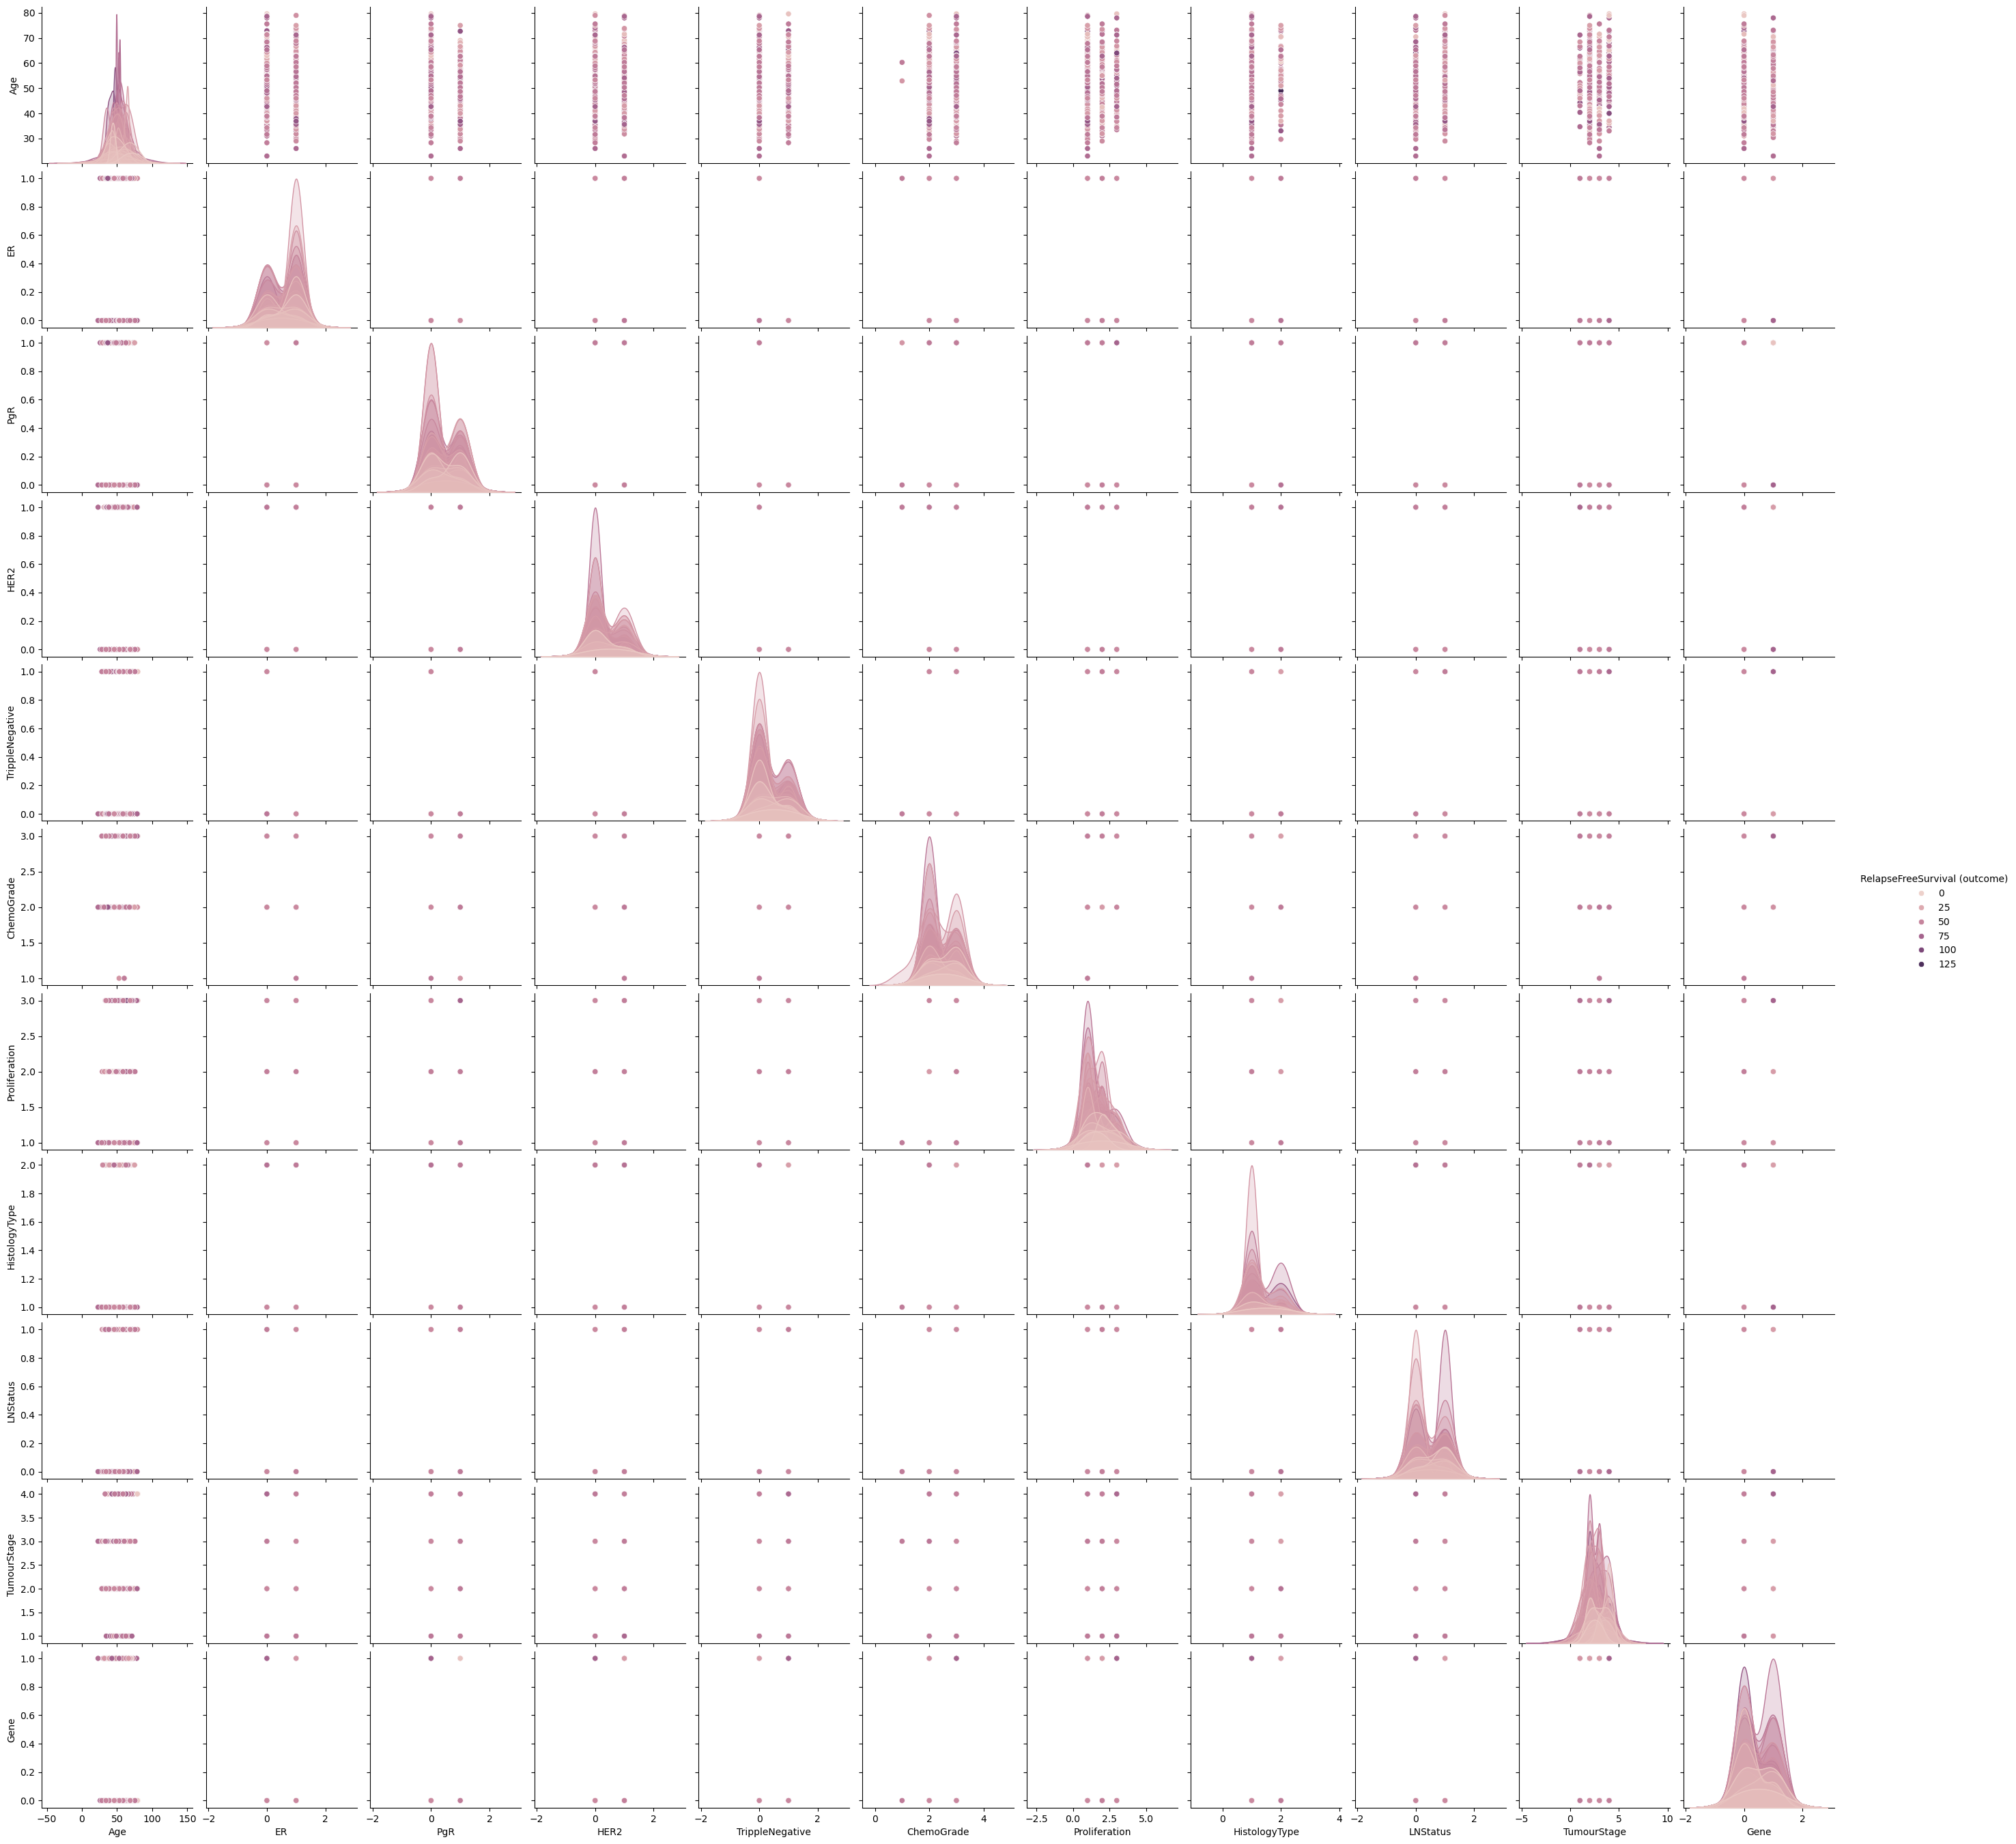

In [9]:
#scatterplots of RFS against clinical features

sns.pairplot(df[list(df.columns[2:13]) + [target]], hue=target)

In [18]:
corr_pcr = df.corr()[target].abs().sort_values(ascending=False)

corr_pcr = corr_pcr.drop(target)

top20_pcr = corr_pcr.head(20)
print(top20_pcr)

print(df['original_firstorder_MeanAbsoluteDeviation'].corr(df[target]))
print(df['original_firstorder_RobustMeanAbsoluteDeviation'].corr(df[target]))
print(df['original_firstorder_InterquartileRange'].corr(df[target]))

original_firstorder_MeanAbsoluteDeviation          0.177346
original_firstorder_RobustMeanAbsoluteDeviation    0.175414
original_firstorder_InterquartileRange             0.170922
original_firstorder_Variance                       0.150695
original_firstorder_Range                          0.149124
original_firstorder_90Percentile                   0.143918
original_shape_MajorAxisLength                     0.142669
original_firstorder_Maximum                        0.135322
original_shape_Maximum3DDiameter                   0.132326
TumourStage                                        0.129854
original_shape_Maximum2DDiameterSlice              0.125917
original_shape_Maximum2DDiameterRow                0.125150
original_firstorder_Kurtosis                       0.124260
original_firstorder_RootMeanSquared                0.123552
original_shape_Sphericity                          0.122357
original_shape_Maximum2DDiameterColumn             0.120210
original_shape_MinorAxisLength          

### Visualising pCR distribution and correlations with features

pCR (outcome)
0.0    311
1.0     84
Name: count, dtype: int64


<Axes: xlabel='pCR (outcome)', ylabel='count'>

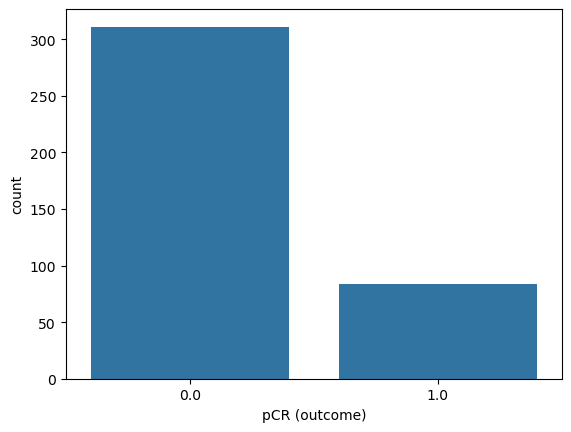

In [11]:
print(df['pCR (outcome)'].value_counts())
sns.countplot(x="pCR (outcome)", data=df)

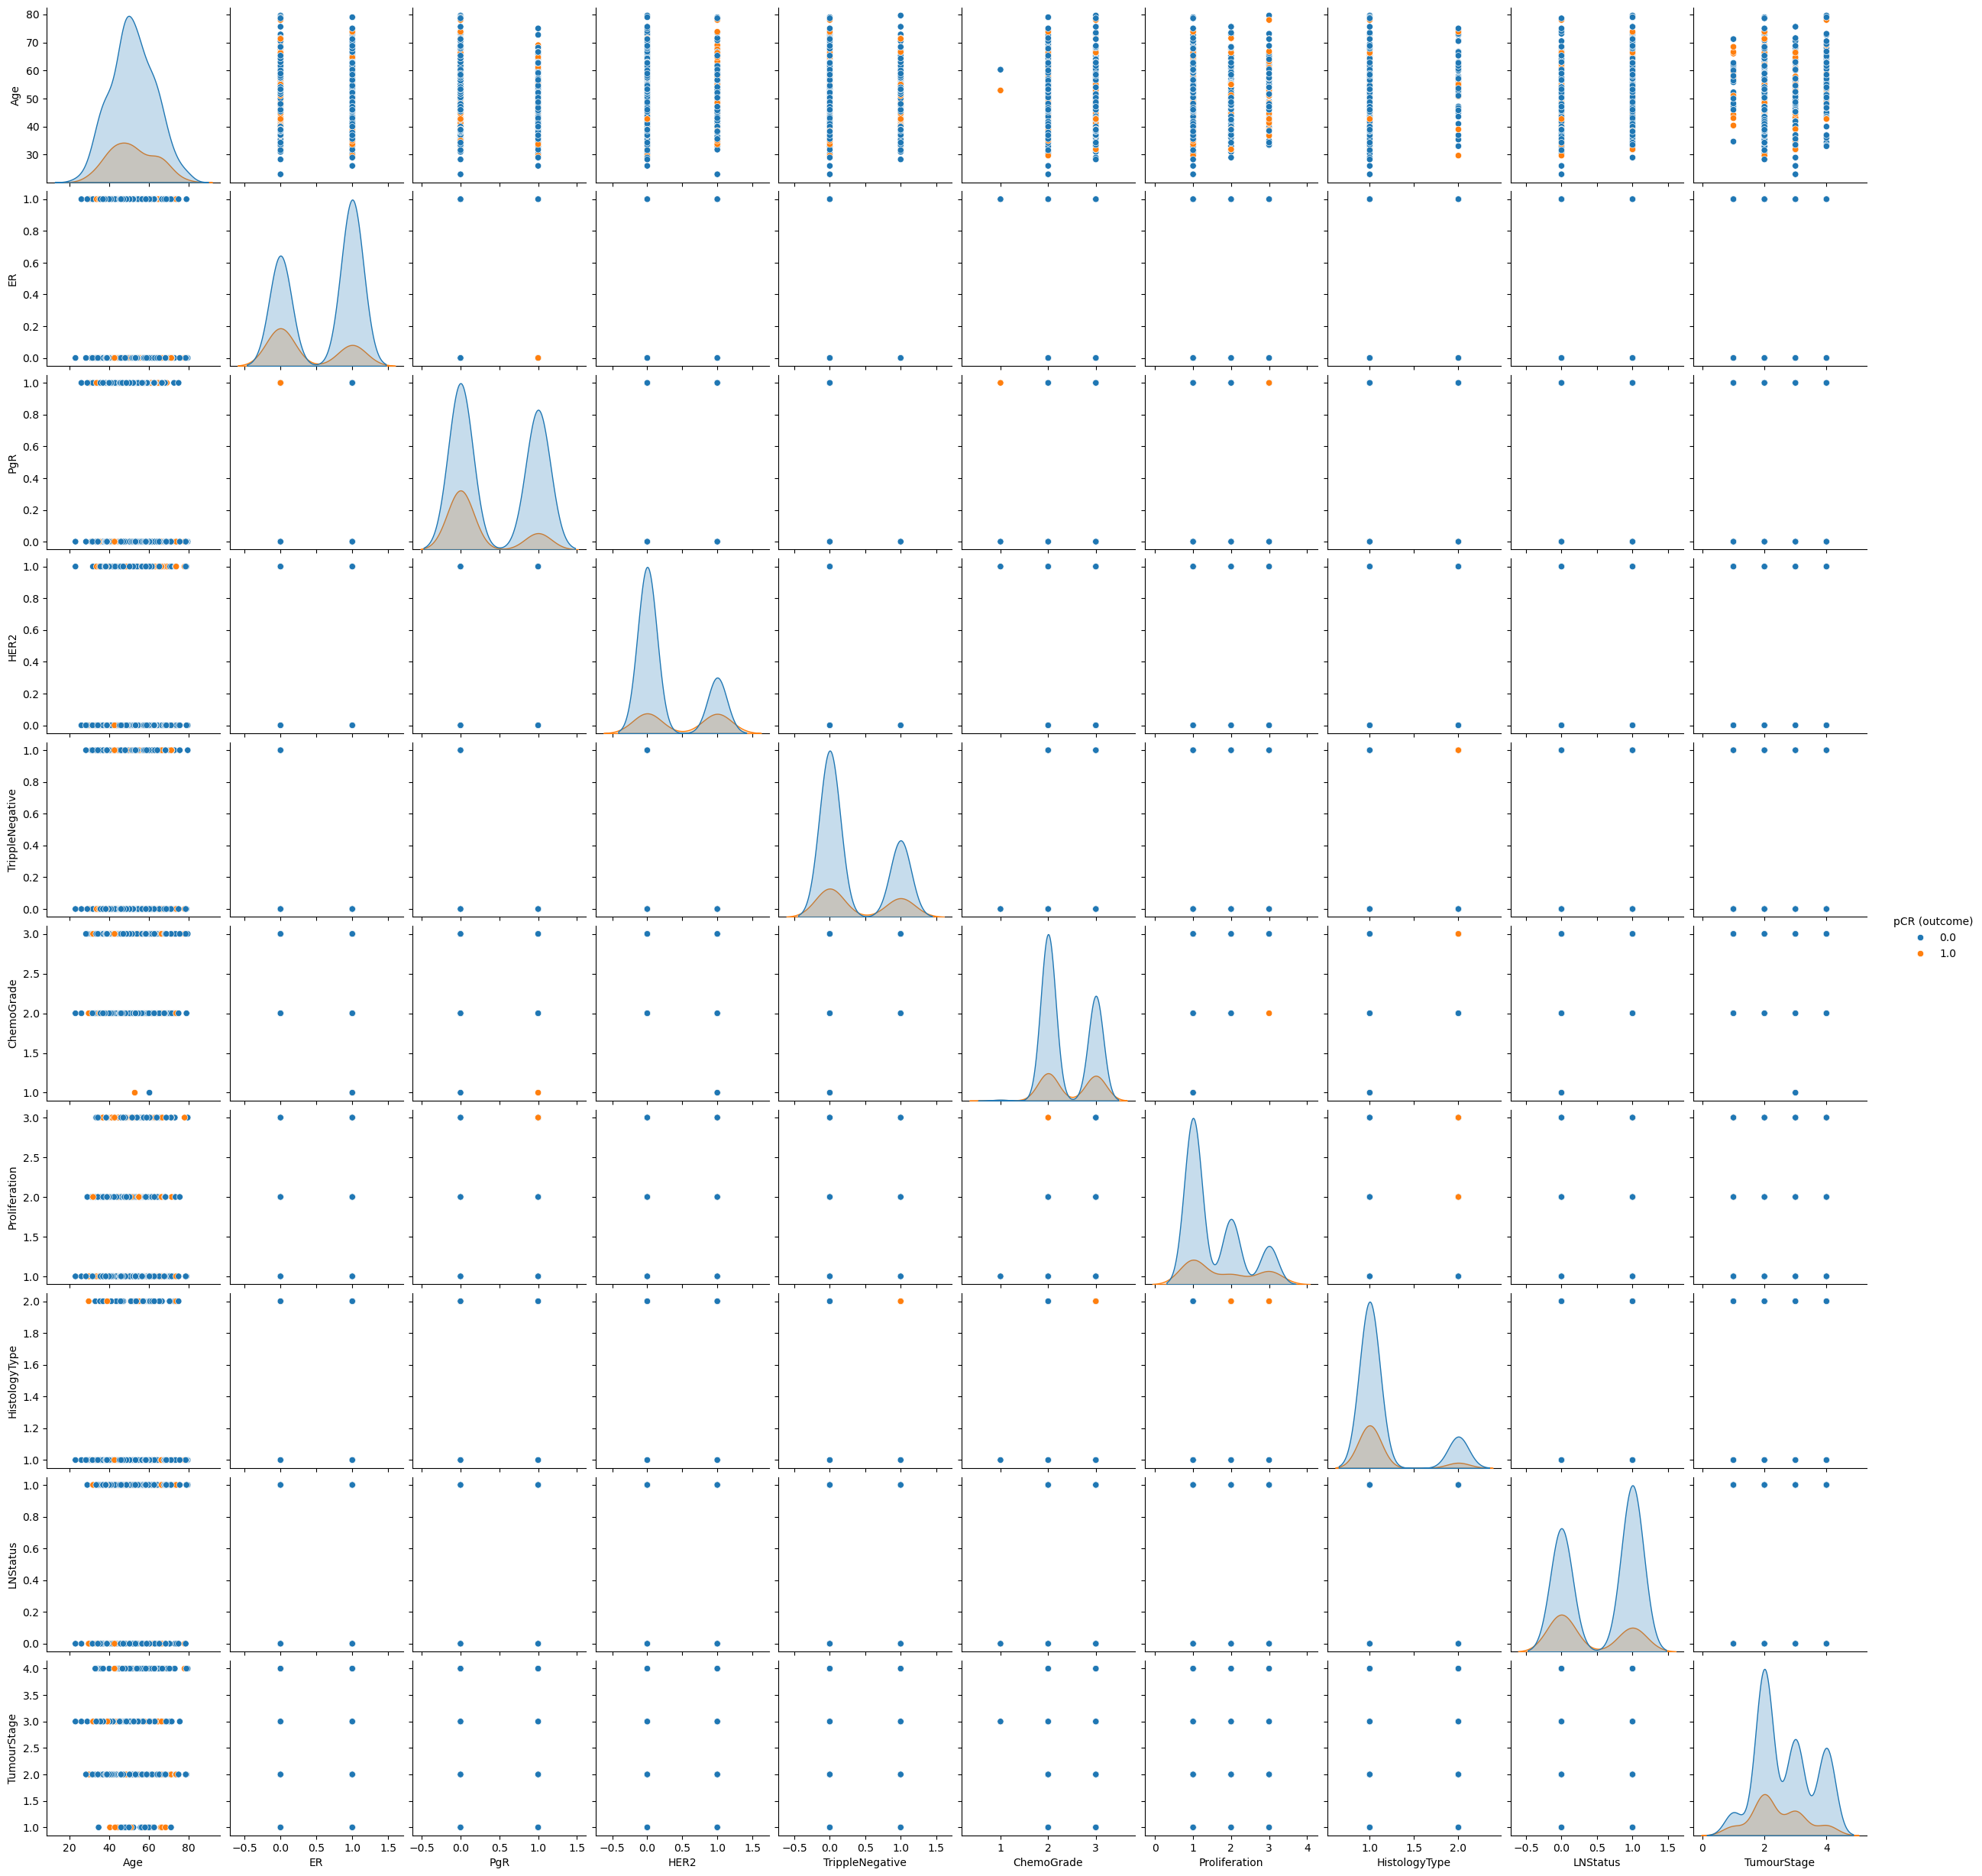

In [12]:
#scatterplots of RFS against clinical features

sns.pairplot(df[list(df.columns[2:12]) + ["pCR (outcome)"]], hue="pCR (outcome)")

In [ ]:
corr_pcr = df.corr()['pCR (outcome)'].abs().sort_values(ascending=False)

corr_pcr = corr_pcr.drop('pCR (outcome)')

top20_pcr = corr_pcr.head(20)
print(top20_pcr)

Gene                                               0.424465
HER2                                               0.215970
ER                                                 0.200782
PgR                                                0.199050
original_glrlm_RunPercentage                       0.173460
original_gldm_LargeDependenceEmphasis              0.171586
original_firstorder_10Percentile                   0.150102
LNStatus                                           0.148915
original_glrlm_RunLengthNonUniformityNormalized    0.146893
original_gldm_DependenceEntropy                    0.142371
original_glrlm_RunEntropy                          0.137242
original_glcm_Id                                   0.128807
original_glcm_Idm                                  0.128807
original_glcm_Contrast                             0.128807
original_glcm_DifferenceAverage                    0.128807
original_glcm_InverseVariance                      0.128807
original_glcm_Idn                       

# Data Preprocessing 

In [ ]:
#data cleaning and imputation
X_train, X_test, y_train, y_test, imputer, scaler = preprocess_data(df, outcomes, target)

In [6]:
#data augmentation 
X_train_aug, y_train_aug = augment_data_smoter(X_train, y_train)

Original train size: 320
Augmented train size: 592


# Dimensionaility Reduction (PCA)

In [ ]:
#selective PCA if mandatory_indices not None
mandatory_indices = [None]

#non-PCA
X_train_npca = X_train_aug
X_test_npca  = X_test
input_dim_npca = X_train_npca.shape[1]

#PCA: 95%
X_train_pca, X_test_pca, pca, n_components = apply_PCA(X_train_aug, X_test, mandatory_indices,0.95)
input_dim_pca = X_train_pca.shape[1]

#PCA: 90%
X_train_pca2, X_test_pca2, pca2, n_components2 = apply_PCA(X_train_aug, X_test, mandatory_indices, 0.90)
input_dim_pca2 = X_train_pca2.shape[1]

#should add plot

# Hyperparameter Tuning 

In [11]:
#hyperparam tuning

npca_tuner = run_hyperband_tuner(build_ANN, input_dim_npca ,X_train_npca, y_train_aug, 'NPCA_AUG3_Tuner')

best_npca = npca_tuner.get_best_models(1)[0]
best_npca_hp = npca_tuner.get_best_hyperparameters(1)[0]


Trial 90 Complete [00h 00m 20s]
val_mae: 37.85948181152344

Best val_mae So Far: 23.71479034423828
Total elapsed time: 00h 11m 19s


In [13]:
pca_tuner = run_hyperband_tuner(build_ANN, input_dim_pca, X_train_pca, y_train_aug, 'PCA_AUG3_Tuner')

best_pca = pca_tuner.get_best_models(1)[0]
best_pca_hp = pca_tuner.get_best_hyperparameters(1)[0]

Trial 91 Complete [00h 00m 20s]
val_mae: 43.94023132324219

Best val_mae So Far: 25.047391891479492
Total elapsed time: 00h 12m 54s


In [14]:
pca2_tuner = run_hyperband_tuner(build_ANN, input_dim_pca2, X_train_pca2, y_train_aug, 'PCA2_AUG3_Tuner')

best_pca2 = pca2_tuner.get_best_models(1)[0]
best_pca2_hp = pca2_tuner.get_best_hyperparameters(1)[0]

Trial 90 Complete [00h 00m 20s]
val_mae: 43.7232666015625

Best val_mae So Far: 25.4855899810791
Total elapsed time: 00h 14m 00s


In [15]:
%load_ext tensorboard
%tensorboard --logdir pipeline/logs

Reusing TensorBoard on port 6006 (pid 25732), started 8:35:27 ago. (Use '!kill 25732' to kill it.)

# Final Model Training and Evaluation

In [16]:
y_train_aug = np.array(y_train_aug).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [17]:
#training models on full training set and evaluating on test set

history_npca, metrics_npca = train_and_save(
    'npca_AUG3',
    best_npca,
    best_npca_hp,
    X_train_npca,
    y_train_aug,
    X_test_npca,
    y_test
)

history_pca, metrics_pca = train_and_save(
    'pca_AUG3',
    best_pca,
    best_pca_hp,
    X_train_pca,
    y_train_aug,
    X_test_pca,
    y_test
)

history_pca2, metrics_pca2 = train_and_save(
    'pca2_AUG3',
    best_pca2,
    best_pca2_hp,
    X_train_pca2,
    y_train_aug,
    X_test_pca2,
    y_test
)

print("Non-PCA Test MAE:", metrics_npca['test_mae'])
print("PCA (95%) Test MAE:", metrics_pca['test_mae'])
print("PCA (90%) Test MAE:", metrics_pca2['test_mae'])

Epoch 1/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 623.9751 - mae: 19.7740 - val_loss: 1119.3036 - val_mae: 26.4050
Epoch 2/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 558.7418 - mae: 18.6121 - val_loss: 1081.3689 - val_mae: 25.8055
Epoch 3/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 546.3734 - mae: 18.4857 - val_loss: 1352.1202 - val_mae: 26.4433
Epoch 4/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 535.8273 - mae: 18.3335 - val_loss: 1005.2370 - val_mae: 24.6646
Epoch 5/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 556.9390 - mae: 18.1460 - val_loss: 1223.5321 - val_mae: 26.3954
Epoch 6/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 513.0233 - mae: 17.9495 - val_loss: 1353.4761 - val_mae: 25.4045
Epoch 7/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 539.2660 - mae: 18.0867 - val_loss: 1050.4860 - val_mae: 26.0780
Epoch 8/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 486.9059 - mae: 17.2940 - val_loss: 1195.0081 - val_mae: 26.1018
Epoch 9/

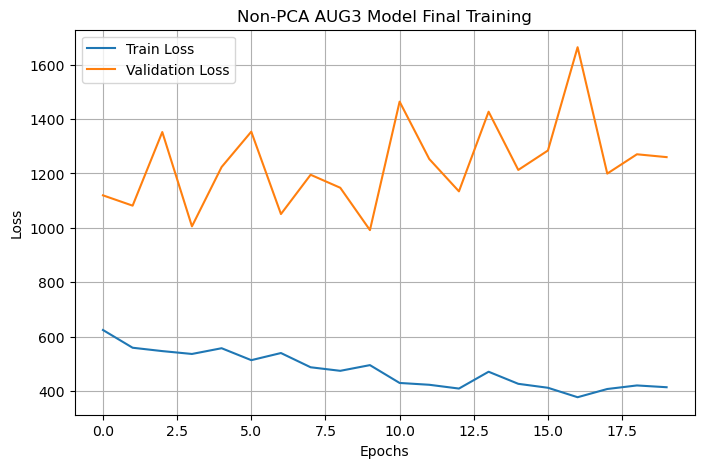

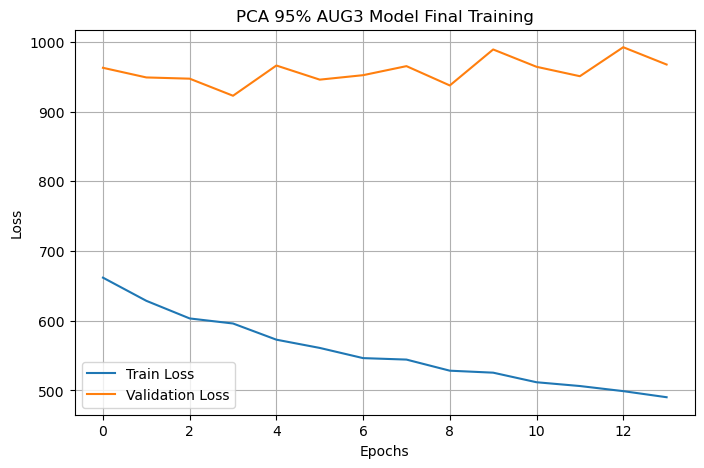

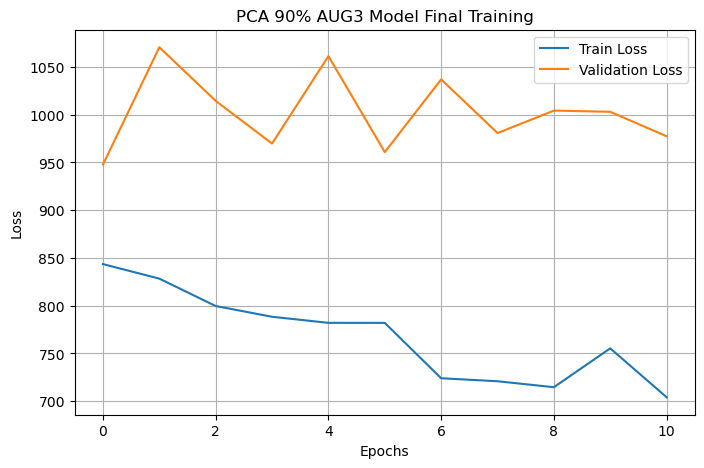

In [18]:
#visualising training process

plot_history('npca_AUG3', history_npca, 'Non-PCA AUG3 Model Final Training')
plot_history('pca_AUG3', history_pca, 'PCA 95% AUG3 Model Final Training')
plot_history('pca2_AUG3', history_pca2, 'PCA 90% AUG3 Model Final Training')
